### Reading in Data

In [1]:
import numpy as np
import pandas as pd
import sklearn as sklearn

In [2]:
dataset = pd.read_csv('blin_interactions.csv', na_filter=False)
#only look at comments and tags
dataset = dataset[['Interaction Territory Country', 'Interaction Dt', 'Hcp Feedback', 'Hcp Comments', 'Hcp Insight', 'Actionable']]
dataset.head()

,Interaction Territory Country,Interaction Dt,Hcp Feedback,Hcp Comments,Hcp Insight,Actionable
0,BeLux,5/31/2021,Vedefar - pump support,Vedefar - pump support,,
1,Bulgaria,1/13/2020,ALL Assembly 2020 - details sent,ALL Assembly 2020 - details sent,,
2,Bulgaria,1/14/2020,Blincyto Regulatory training,Blincyto Regulatory training,,
3,Bulgaria,1/27/2020,ALL Assembly 2020 - certificate of attendance ...,ALL Assembly 2020 - certificate of attendance ...,,
4,Bulgaria,1/27/2020,ALL Assembly 2020 - certificate of attendance ...,ALL Assembly 2020 - certificate of attendance ...,,


In [3]:
#Combine redundant columns 15-17 (make them one column -> Hcp Feedback)

for i in range(0, len(dataset)):
    comment = str(dataset['Hcp Feedback'][i])
    if not comment:
        if dataset['Hcp Comments'][i]:
            dataset['Hcp Feedback'][i] = dataset['Hcp Comments'][i]
        else:
            dataset['Hcp Feedback'][i] = dataset['Hcp Insight'][i]

dataset.pop('Hcp Comments')
dataset.pop('Hcp Insight')
dataset.head()

,Interaction Territory Country,Interaction Dt,Hcp Feedback,Actionable
0,BeLux,5/31/2021,Vedefar - pump support,
1,Bulgaria,1/13/2020,ALL Assembly 2020 - details sent,
2,Bulgaria,1/14/2020,Blincyto Regulatory training,
3,Bulgaria,1/27/2020,ALL Assembly 2020 - certificate of attendance ...,
4,Bulgaria,1/27/2020,ALL Assembly 2020 - certificate of attendance ...,


In [4]:
#If actionable 'y', tag as 1, else tag as 0

for i in range(0, len(dataset)):
    if dataset['Actionable'][i] == 'y':
        dataset['Actionable'][i] = 1
    else:
        dataset['Actionable'][i] = 0

In [5]:
#Check class distribution of actionable
act_classes = dataset['Actionable']
print(act_classes.value_counts())

0    6974
1     715
Name: Actionable, dtype: int64


### Pre-Processing Data

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [7]:
#Lowercase, split, and lemmatize comments
cleaned_data = []
indices = []

for i in range(0, len(dataset['Hcp Feedback'])):
    
    comment = re.sub('[^a-zA-Z0-9]' , ' ' , dataset['Hcp Feedback'][i])
    #comment = translator.translate(comment).text
    comment = comment.lower()
    comment = comment.split()
 
    wl = WordNetLemmatizer()
    comment = [wl.lemmatize(word) for word in comment] #if not word in set(stopwords.words('english'))]
    comment = [w for w in comment if wordnet.synsets(w,pos='n',lang='eng')]
    comment = ' '.join(comment)
    cleaned_data.append(comment)
    indices.append(i)

In [8]:
len(cleaned_data)

7689

In [9]:
#Remove comments that are blank after cleaning
#new_ind keeps indices of original comments in cleaned_data, helpful for keeping track of original comments in later steps
processed_data = []
new_ind = []

for i in range(0, len(cleaned_data)):
    comment = cleaned_data[i]
    if comment:
        processed_data.append(comment)
        new_ind.append(indices[i])

In [10]:
len(processed_data)

7112

In [11]:
#This is what was removed from the original dataset after cleaning:

#for i in range(0, len(dataset)):
    #if i not in new_ind:
        #print(dataset['Hcp Feedback'][i])

In [12]:
#Get actionable status of just the processed data (blanks removed)
new_act = []

for i in new_ind:
    new_act.append(dataset['Actionable'][i])

In [13]:
#Zip processed comment data together with their actionable status
processed_dataset = list(zip(processed_data, new_act))
df = pd.DataFrame(processed_dataset,
                  columns = ['Comments', 'Actionable'])

### TF-IDF

In [14]:
#Use built-in TF-IDF vectorizer to get array of scores for each feature, each comment
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(processed_data)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
feature_df = pd.DataFrame(denselist, columns=feature_names)

In [15]:
feature_df

,10,100,1000,10000,100000,11,12,13,14,15,...,year,yes,yesterday,yield,york,young,yr,zill,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.22743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
count = 0
for i in range(0, feature_df.shape[1]):
    count += feature_df.iloc[0,i]

print(count)

1.4112508897552174


In [16]:
#X is the TF-IDF feature matrix
X = feature_df
X.shape

(7112, 3209)

In [17]:
#Y is the actionable status tags
Y = df['Actionable']
Y.shape

(7112,)

In [18]:
#Checking that we have two classes in Y
np.unique(Y)

array([0, 1], dtype=int64)

### Undersampling to Adjust for Class Imbalance

In [19]:
import seaborn as sns

In [20]:
target = 'Actionable'
minority_class_len = len(df[df[target] == 1])
print(minority_class_len)

715


<AxesSubplot:xlabel='Actionable', ylabel='count'>

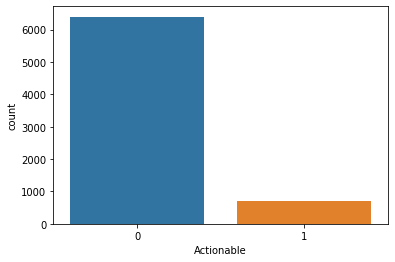

In [21]:
sns.countplot(x=target, data=df)

In [22]:
#Find indices of majority class (Not Actionable)

majority_class_indices = df[df[target] == 0].index
print(majority_class_indices)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7098, 7099, 7101, 7103, 7104, 7107, 7108, 7109, 7110, 7111],
           dtype='int64', length=6397)


In [23]:
#Find indices of minority class (Actionable)

minority_class_indices = df[df[target] == 1].index
print(minority_class_indices)

Int64Index([ 505,  507,  514,  518,  525,  526,  858,  926,  968,  976,
            ...
            7077, 7078, 7082, 7086, 7088, 7096, 7100, 7102, 7105, 7106],
           dtype='int64', length=715)


In [24]:
#Randomly pick the number of majority class to be equal to minority
random_majority_indices = np.random.choice(majority_class_indices,
                                           minority_class_len, 
                                           replace=False)
print(len(random_majority_indices))

715


In [25]:
#Rejoin minority and majority
under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])

In [26]:
under_sample = df.loc[under_sample_indices]

<AxesSubplot:xlabel='Actionable', ylabel='count'>

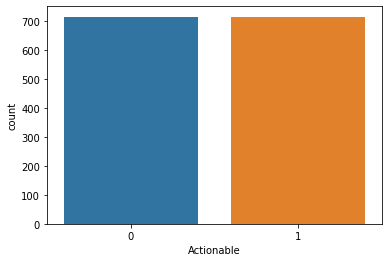

In [27]:
sns.countplot(x=target, data=under_sample)

In [28]:
len(under_sample)

1430

### Training and Testing

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [30]:
#New X and Y with undersampling
X = feature_df.loc[under_sample_indices]
Y = under_sample['Actionable']

In [31]:
#Split training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print('Training:', len(Y_train))
print('Testing:', len(Y_test))

Training: 1001
Testing: 429


In [32]:
#Fit data to logistic regression
clf = LogisticRegression().fit(X_train, Y_train.values.ravel())
Y_Test_Pred = clf.predict(X_test)

In [33]:
Y_Test_Pred

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,

In [34]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
    pass

In [35]:
generate_model_report(Y_test, Y_Test_Pred)

Accuracy =  0.8181818181818182
Precision =  0.801762114537445
Recall =  0.8465116279069768
F1 Score =  0.8235294117647058


In [36]:
#Print actionable items- start by getting indices of original comments
#ind = indices of only actionable items
ind = []

for i in range(0, len(Y_Test_Pred)):
    item = Y_Test_Pred[i]
    if item == 1:
        ind.append(i)

comment_indices = []
for i in ind:
    comment_indices.append(X.iloc[i].name)

In [37]:
#Make list of actionable items detected with ML!
act_lst = []

for i in comment_indices:
    index = new_ind[i]
    item = []
    item.append(index+2)
    item.append(dataset['Hcp Feedback'][index])
    act_lst.append(item)

In [38]:
#Print out a sample of 10 items from actionable items list

import random
lst = list(range(len(act_lst)))
random_indices = random.sample(lst, 10)

for i in range(0, len(act_lst)):
    if i in random_indices:
        print('{}. {}'.format(act_lst[i][0], act_lst[i][1]))


2219. The group was upset because of ISS refuse. Brazilian data is very important to give opportunity of new technology use and local pharmacoeconomic analysis.
2265. Discussion with data MOLACT1 and how CF or NGS could help to underestand better the patient - in his opinion, the more sensitive the test the better.
2395. Public access is essential for patient perspective. In her institution more than 70% of patients came from public system and with the new evidences in HR RR first relapse children is the best for the patient
2950. •	In response to your below question, he mentioned that he just had a case in the last month where Blinatumomab was approved in first relapse. 
•	He’s excited about the NOC for patients with MRD+ which he felt will help accessing Blin at first relapse. 
•	We discussed how the major issue related to INESSS listing criteria of CAR-T not allowing for any prior anti-CD19 therapy is limiting their use of Blin. He mentioned that Novartis was doing a lot of noise to

### Analysis by Country

In [39]:
#Make list of all countries with actionable items detected
act_countries = []

for item in act_lst:
    country = dataset['Interaction Territory Country'][item[0]]
    if country not in act_countries:
        act_countries.append(country)

In [40]:
act_countries

['Poland',
 'AR',
 'BR',
 'CA',
 'CO',
 'Gulf States',
 'Maghreb',
 'MX',
 'South Africa']

In [41]:
#All countries in dataset
all_countries = []

for comment in dataset['Interaction Territory Country']:
    if comment not in all_countries:
        all_countries.append(comment)

In [42]:
#Initializing dicts to all zeros
country_counts = dict.fromkeys(act_countries,0)
country_totals = dict.fromkeys(all_countries,0)

In [43]:
#Get counts of actionable items in each country (some countries have none)
for item in act_lst:
    country = dataset['Interaction Territory Country'][item[0]]
    country_counts[country] +=1

In [44]:
country_counts

{'Poland': 4,
 'AR': 4,
 'BR': 101,
 'CA': 14,
 'CO': 39,
 'Gulf States': 5,
 'Maghreb': 47,
 'MX': 11,
 'South Africa': 2}

In [45]:
#Get totals for each country
for comment in dataset['Interaction Territory Country']:
    country_totals[comment] +=1

In [46]:
#Percentage of actionable items by country
percent_actionable = {}
for (key,value) in country_totals.items():
    if key in country_counts:
        percent_actionable[key] = country_counts[key]/value * 100

In [47]:
percent_actionable

{'Poland': 4.878048780487805,
 'AR': 0.7936507936507936,
 'BR': 7.271418286537077,
 'CA': 7.253886010362693,
 'CO': 12.786885245901638,
 'Gulf States': 1.9920318725099602,
 'Maghreb': 6.368563685636857,
 'MX': 2.301255230125523,
 'South Africa': 5.0}

### Apply to XGEVA Dataset - Test!

In [48]:
#Read in new dataset
new_dataset = pd.read_csv('xgeva_interactions.csv', na_filter=False)
#only look at comments and tags
new_dataset = new_dataset[['interaction_dt', 'hcp_comments']]
new_dataset.head()

,interaction_dt,hcp_comments
0,6/25/2020,We talked about risk of hypocalcemia in patien...
1,9/2/2020,XGEVA safety aspects.
2,11/7/2020,"Lung cancer is the second cancer in men, 3000 ..."
3,3/17/2021,Xgeva is not cost-effective when compared to z...
4,7/6/2020,We talked about the ONJ incidence and about th...


In [49]:
#Clean and preprocess data
new_cleaned_data = []
new_indices = []

for i in range(0, len(new_dataset['hcp_comments'])):
    
    comment = re.sub('[^a-zA-Z0-9]' , ' ' , new_dataset['hcp_comments'][i])
    #comment = translator.translate(comment).text
    comment = comment.lower()
    comment = comment.split()
 
    wl = WordNetLemmatizer()
    comment = [wl.lemmatize(word) for word in comment] #if not word in set(stopwords.words('english'))]
    comment = [w for w in comment if wordnet.synsets(w,pos='n',lang='eng')]
    comment = ' '.join(comment)
    new_cleaned_data.append(comment)
    new_indices.append(i)

In [50]:
#Remove comments that are blank after cleaning
new_processed_data = []
new_processed_ind = []

for i in range(0, len(new_cleaned_data)):
    comment = new_cleaned_data[i]
    if comment:
        new_processed_data.append(comment)
        new_processed_ind.append(new_indices[i])

In [51]:
len(new_processed_data)

13155

In [53]:
#Use TF-IDF vectorizer that has been fit to previous dataset to transform new comment data
tfidf = TfidfVectorizer()
tfidf.fit(processed_data)

dense = tfidf.transform(new_processed_data).todense()
denselist = dense.tolist()
new_feature_df = pd.DataFrame(denselist, columns=feature_names)

In [54]:
new_feature_df

,10,100,1000,10000,100000,11,12,13,14,15,...,year,yes,yesterday,yield,york,young,yr,zill,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
X_test = new_feature_df
print(X_test.shape)

(13155, 3209)


In [56]:
#Training will be taken from previous dataset 
X_train = feature_df
print(X_train.shape)
Y_train = Y = df['Actionable']
print(Y_train.shape)

(7112, 3209)
(7112,)


In [57]:
clf = LogisticRegression().fit(X_train, Y_train.values.ravel())
Y_Test_Pred = clf.predict(X_test)

In [58]:
#Print actionable items- start by getting indices of original comments
#ind = indices of only actionable items
ind = []

for i in range(0, len(Y_Test_Pred)):
    item = Y_Test_Pred[i]
    if item == 1:
        ind.append(i)

comment_indices = []
for i in ind:
    comment_indices.append(X_test.iloc[i].name)

In [59]:
#Print out actionable items detected with ML!
#Remove duplicates (a lot in this dataset)
act_lst = []

for i in comment_indices:
    index = new_processed_ind[i]
    item = []
    item.append(index+1)
    item.append(new_dataset['hcp_comments'][index])
    act_lst.append(item)


print_lst = []
for item in act_lst:
    if item[1] not in print_lst:
        print('{}. {}'.format(item[0], item[1]))
    print_lst.append(item[1])

167. There are 2 patients being treated with denosumab.
461. There are 2 patients being treated with Denosumab.
638. â—‹ Frequency of dosing: 
		â—‹ patients are willing to take a monthly therapy for the first year, but after the first year they need less frequent dosing.  Quote: "This is very, very important. No one wants to be here more than every two weeks, ideally no more often than every 4 weeks"  
		â—‹ Q1wk dosing is not clinically preferred, especially if there is a Q3wk option
		â—‹ XGEVA mentioned, and Dr. Kumar said that Mayo uses anti-resorptives every 3 months as an example.
816. Still catching up on surgery backlog due to COVID-19, but currently there is little impact of the pandemic on his practice. Patients are able to get treatment and denosumab injections are not an issue.
2031. Xgeva could more consideration because of its efficacy, ease of administration and less severe side effects. The data of QOL showed benefit. However limitation of cost ,doctors would need to b